### Human In the Loop
Human-in-the-Loop means:
A human steps into an automated AI workflow to review, approve, correct, or guide the AI before it continues.

It is NOT fully autonomous AI.
It is AI + Human collaboration.
HITL = Human checks → gives feedback → AI updates output

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action
(2) Debugging - We can rewind the graph to reproduce or avoid issues
(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

HITL is used to:
✔ Prevent mistakes
✔ Improve accuracy
✔ Reduce hallucinations
✔ Add human judgment or expertise
✔ Add safety and compliance
✔ Provide supervision during complex decisions

USE HITL when:
✔ Mistakes are expensive
✔ You need compliance or safety
✔ The task is sensitive
✔ AI confidence is low
✔ You need expert judgment
✔ You need brand or tone consistency
✔ You expect AI hallucinations

Where HITL Is Used (Practical, Real Examples)
1. Content Review
AI writes a document → Human approves it before publishing
AI generates email → Human edits then sends
AI produces legal/medical/financial content → Human must verify

2. Data Labeling / RLHF=> IMPORTANT
Humans:
Rate AI responses
Label training data
Provide corrections
This feedback improves the model.

3. Customer Service
AI drafts responses → humans approve or escalate.

4. Code Generation
AI writes code → human reviews
AI proposes fixes → human checks before pushing to production

5. Moderation

AI flags harmful content → human verifies severity.
6. Autonomous Agents

Agents:

Retrieve info
Make plans
Generate steps

But before executing a risky step → human approval required.

7. Decision-Making
AI proposes:
Hiring recommendations
Medical diagnoses
Financial forecasting
Loan decisions
Human makes final decision.

8. Safety-Critical Systems

Robotics
Self-driving cars
Manufacturing automation
Humans intervene when system is uncertain.

In [1]:
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage,AnyMessage,BaseMessage
from typing_extensions import TypedDict,Annotated,Literal
from pydantic import BaseModel,Field
from IPython.display import Image,display
import operator
import uuid

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph import MessagesState #important ->MessagesState is a prebuilt state class in LangGraph used to store the conversation history of an agent in a structured way.

# AI agents and LLMs often need a message list (similar to OpenAI's messages[] format):
# [
#   {"role": "user", "content": "Hello"},
#   {"role": "assistant", "content": "Hi!"},
#   {"role": "system", "content": "Be helpful."}
# ]

# ⬆ This history is required for the model to understand context.

# MessagesState provides three key things:

# A standardized way to store messages
# A safe way to merge messages when multiple nodes update state
# Avoids recreating your own message schema

# Where to Use MessagesState

# ✔️ 1. Chatbots
# If you’re building a conversational assistant with multiple turns:
# state = MessagesState()
# The graph nodes update the messages automatically.

# ✔️ 2. Agent workflows with message passing
# If your nodes exchange messages (user → LLM → tools → LLM → user).
# Perfect for ReAct-style agents.

# ✔️ 3. Multi-agent conversations
# When agents talk to each other via messages, MessagesState keeps history organized.

# ✔️ 4. Tool-using agents
# Tools produce messages such as:
# Function call request
# Tool response
# Agent response
# MessagesState handles them smoothly.

# ✔️ 5. LangGraph streaming / UI visualization
# LangGraph Studio shows messages cleanly only when using MessagesState.
# So if you want UI-friendly history → use it.

In [2]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [3]:
# # Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="openai/gpt-oss-120b")

In [4]:
llm.invoke("can u tell me the exact what model are u ?")

AIMessage(content='I’m ChatGPT, a large‑language model created by OpenAI.\u202fMy underlying architecture is based on GPT‑4.', additional_kwargs={'reasoning_content': 'The user asks: "can u tell me the exact what model are u ?" They want to know which model. According to policy, we can disclose that we are ChatGPT, a large language model trained by OpenAI, based on GPT-4 architecture. So we can comply. Provide answer.'}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 82, 'total_tokens': 178, 'completion_time': 0.19850402, 'completion_tokens_details': {'reasoning_tokens': 61}, 'prompt_time': 0.003906449, 'prompt_tokens_details': None, 'queue_time': 0.004575334, 'total_time': 0.202410469}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_854fa9be4c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2eec-e5c7-7b60-8c80-d80e0915a400-0', tool_calls=[], invalid_tool_calls=[], usage_m

In [5]:
def multiply(a:int,b:int)-> int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int,b:int)-> int:
    """
    Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a:int,b:int)-> int:
    """
    Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a/b

tools =[add,multiply,divide]

In [6]:
llm_with_tools =llm.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000029BF2B16180>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000029BF2AB7D70>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': '

In [7]:
sys_msg =SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs")

#Node



In [8]:
#  while  this assistant() node logic always produces a brand-new list containing only ONE message, and that one message is always replaced in memory checkpoints.
#so go to next cell logic used below 
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state['messages'])]}

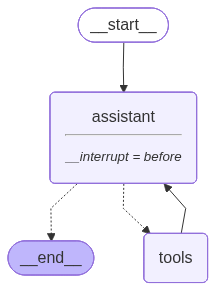

In [9]:
graph =StateGraph(MessagesState)

graph.add_node("assistant",assistant)
graph.add_node("tools",ToolNode(tools=tools))

graph.add_edge(START,"assistant")
graph.add_conditional_edges("assistant",tools_condition)## If the latest message (result) from assistant is a tool call -> tools_condition routes to tools # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
graph.add_edge("tools","assistant")
graph.add_edge("assistant",END)

memory =MemorySaver()

builder =graph.compile(interrupt_before=['assistant'],checkpointer=memory) # an interrupt is a pause in the graph, where the system stops and waits for human input before continuing. here 2 things interrupt_before,interrupt after  
#interrupt_before — Stop before a node runs 

# Interrupt BEFORE sending → stop and ask:
# can i use bank transfer tool ?
# “I am about to send ₹10,000 to John.
# Should I continue?”
# You approve → AI sends.
# You deny → AI stops.

#Interrupt_after - AFTER preparing details → stop and ask:

# AI already generated the transfer details, but has NOT sent money yet.
# Interrupt AFTER preparing details → stop and ask:
# “Here is the transfer summary I prepared:
# Amount: ₹10,000
# Receiver: John
# Is this correct?”

####IMPORANT HERE -?Interrupt_after can fix
# You approve → AI executes.
# You Fix / Edit / Modify → AI updates. ####IMPORANT HERE -?Interrupt_after can Fix / Edit / Modify
# You reject → AI cancels.

display(Image(builder.get_graph().draw_mermaid_png()))

In [10]:
import uuid

In [11]:
config ={"configurable":{"thread_id":str(uuid.uuid4())}}



In [12]:
# thread_id = str(uuid.uuid4())
# config = {"configurable": {"thread_id": thread_id, "checkpoint_ns": "", "checkpoint_id": ""}}

In [13]:
initial_msg ={"messages":HumanMessage(content="multiply 800 by 2")}


In [14]:
for event in builder.stream(input=initial_msg,config=config,stream_mode="values"): #graph.stream or builder.stream is executing from current state 
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 800 by 2


## This image is very important

![alt text](download.png)

In [15]:
graph =builder.get_state(config)
graph

StateSnapshot(values={'messages': [HumanMessage(content='multiply 800 by 2', additional_kwargs={}, response_metadata={}, id='2e9a2add-32cc-4ce4-9d03-e3481febf5f5')]}, next=('assistant',), config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d07d-6ffa-8000-4d2b0641f9dc'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-05T17:50:09.439129+00:00', parent_config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d065-64c0-bfff-e50279d978a0'}}, tasks=(PregelTask(id='55e9b346-dfe9-3192-fac5-7232510bfc1b', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [16]:
graph.next

('assistant',)

In [17]:
builder.get_state_history(config)# to display this generator content used code below

<generator object Pregel.get_state_history at 0x0000029BFEFD6DA0>

In [18]:
history = list(builder.get_state_history(config))
history


[StateSnapshot(values={'messages': [HumanMessage(content='multiply 800 by 2', additional_kwargs={}, response_metadata={}, id='2e9a2add-32cc-4ce4-9d03-e3481febf5f5')]}, next=('assistant',), config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d07d-6ffa-8000-4d2b0641f9dc'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-05T17:50:09.439129+00:00', parent_config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d065-64c0-bfff-e50279d978a0'}}, tasks=(PregelTask(id='55e9b346-dfe9-3192-fac5-7232510bfc1b', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d065-64c0-bf

In [19]:
for step in builder.get_state_history(config):
    print(step)


StateSnapshot(values={'messages': [HumanMessage(content='multiply 800 by 2', additional_kwargs={}, response_metadata={}, id='2e9a2add-32cc-4ce4-9d03-e3481febf5f5')]}, next=('assistant',), config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d07d-6ffa-8000-4d2b0641f9dc'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-05T17:50:09.439129+00:00', parent_config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d065-64c0-bfff-e50279d978a0'}}, tasks=(PregelTask(id='55e9b346-dfe9-3192-fac5-7232510bfc1b', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())
StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '43be978f-3593-489e-94f9-f22814b75956', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb1-d065-64c0-bfff-

In [20]:
import pandas as pd

history = list(builder.get_state_history(config))
df = pd.DataFrame(history)
df


,values,next,config,metadata,created_at,parent_config,tasks,interrupts
0,{'messages': [content='multiply 800 by 2' addi...,"(assistant,)",{'configurable': {'thread_id': '43be978f-3593-...,"{'source': 'loop', 'step': 0, 'parents': {}}",2026-02-05T17:50:09.439129+00:00,{'configurable': {'thread_id': '43be978f-3593-...,"((55e9b346-dfe9-3192-fac5-7232510bfc1b, assist...",()
1,{'messages': []},"(__start__,)",{'configurable': {'thread_id': '43be978f-3593-...,"{'source': 'input', 'step': -1, 'parents': {}}",2026-02-05T17:50:09.429011+00:00,None,"((64ff6786-a8e6-717b-a966-4c3a4941b5ed, __star...",()


In [21]:
# for event in builder.stream(input=None,config=config,stream_mode="values"): #graph.stream or builder.stream is executing from current state 
#     event['messages'][-1].pretty_print()

In [22]:
## Continue the execution of Assistant and then end
for event in builder.stream(None,config=config,stream_mode="values"): #none means not passing any message-> telling that continue and allowed kind of 
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 800 by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_25f05878-b375-4068-98e1-d9ec992d3fe7)
 Call ID: fc_25f05878-b375-4068-98e1-d9ec992d3fe7
  Args:
    a: 800
    b: 2
================================= Tool Message =================================
Name: multiply

1600


In [23]:
graph.next #Here it is in assistant still because again interrupted (when comes to assistance node it will be interrupted)

('assistant',)

In [24]:
for event in builder.stream(None,config=config,stream_mode="values"): #now pass again from assistant to end
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

1600
================================== Ai Message ==================================

The result is **1600**.


##### Edit the HITL (Human In the loop)

In [25]:
config ={"configurable":{"thread_id":"2"}}

In [26]:
initial_msg ={"messages":HumanMessage(content="multiply 6 by 2")}

for event in builder.stream(input=initial_msg,config=config,stream_mode="values"): #now pass again from assistant to end
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 6 by 2


In [27]:
state=builder.get_state(config=config)
state

StateSnapshot(values={'messages': [HumanMessage(content='multiply 6 by 2', additional_kwargs={}, response_metadata={}, id='96bf241d-8147-4e71-8fbc-8f9d9a90d28c')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb2-2ade-6a4c-8000-3a8bd040bb95'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-05T17:50:18.915898+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f102bb2-2ac9-63c2-bfff-ba376bd47662'}}, tasks=(PregelTask(id='ba9496e5-69ec-b1e6-8087-e9d32ca6c73a', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [28]:
state.next

('assistant',)

In [29]:
builder.update_state(config,{"messages":[HumanMessage(content="change to multiply 999 with 77")]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f102bb2-2b98-6122-8001-00575af2f011'}}

In [30]:
state =builder.get_state(config).values

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 6 by 2
================================ Human Message =================================

change to multiply 999 with 77


In [31]:
for event in builder.stream(None,config=config,stream_mode="values"): #now pass from assistant to tools
    event['messages'][-1].pretty_print()

================================ Human Message =================================

change to multiply 999 with 77
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_6cc39923-5833-4e04-8787-c1aa6dcd0d40)
 Call ID: fc_6cc39923-5833-4e04-8787-c1aa6dcd0d40
  Args:
    a: 999
    b: 77
================================= Tool Message =================================
Name: multiply

76923


In [32]:
for event in builder.stream(None,config=config,stream_mode="values"): #now tool to assistant then pass again from assistant to end
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

76923
================================== Ai Message ==================================

The product of 999 and 77 is **76,923**.


### Workflow will wait for user input

In [34]:
memory =MemorySaver()


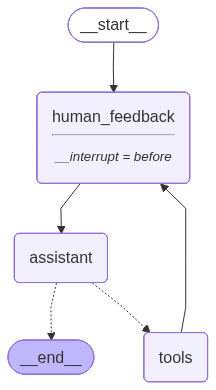

In [37]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def human_feedback(state:MessagesState):
    pass

def assistant(state:MessagesState):
    return {"messages":llm_with_tools.invoke([sys_msg]+state['messages'])}

builder =StateGraph(MessagesState)

builder.add_node("human_feedback",human_feedback)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","human_feedback")
#builder.add_edge("assistant",END)

graph =builder.compile(checkpointer=memory,interrupt_before=["human_feedback"])

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
thread ={"configurable":{"thread_id":"555"}}

In [39]:
initial_msg ={"messages":"multiply 2 and 5"}

for event in graph.stream(initial_msg,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 5


In [41]:
user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

add 88 and 12
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_20dabee5-65b1-47c0-8389-d9da98f1ee03)
 Call ID: fc_20dabee5-65b1-47c0-8389-d9da98f1ee03
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10


In [42]:
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================
Tool Calls:
  add (fc_732225ee-5aa0-44de-b685-969323a6fb25)
 Call ID: fc_732225ee-5aa0-44de-b685-969323a6fb25
  Args:
    a: 88
    b: 12
================================= Tool Message =================================
Name: add

100
